<a href="https://colab.research.google.com/github/derekriceX/Bayesian-Analysis/blob/main/Bike_rent_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
#from scipy import stats
from scipy.stats import beta, norm

In [100]:
!pip install ucimlrepo


In [101]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets

In [102]:
X.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [103]:
y.head()

,cnt
0,16
1,40
2,32
3,13
4,1


In [104]:
# (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39

X['Temp_C'] = X['atemp']*(39-8)+8

X.head()

/tmp/ipython-input-3070228260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Temp_C'] = X['atemp']*(39-8)+8


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,Temp_C
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16.9249
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,16.4537
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,16.4537
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,16.9249
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,16.9249


In [105]:
print(X.shape)
print(y.shape)

(17379, 14)
(17379, 1)


In [106]:
X.head(0)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,Temp_C


In [107]:
y.head(0)

,cnt


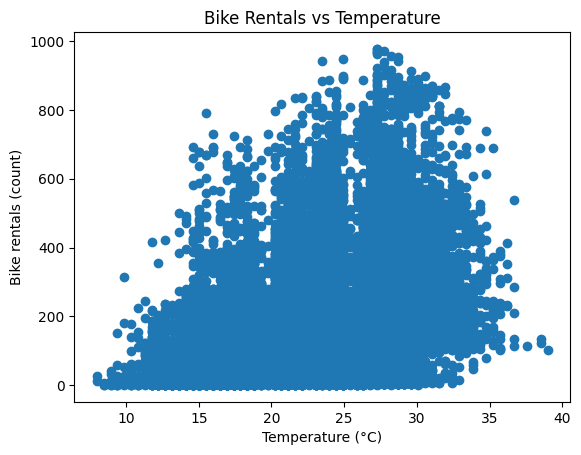

In [108]:
# Align X and y to ensure matching indexes
X_aligned, y_aligned = X.align(y, join='inner', axis=0)

# Now plot
plt.figure()
plt.scatter(X_aligned['Temp_C'], y_aligned['cnt'])
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike rentals (count)")
plt.title("Bike Rentals vs Temperature")
plt.show()


In [109]:
from sklearn.linear_model import LinearRegression

In [110]:
# features (temp) needs to be 2D: shampe (n_samples, 1)
X = X[['Temp_C']] # keeps it as a DataFrame (2D)
y = y['cnt'] # target values

# combine X and y into a single dataframe - address n/a in data
df = pd.concat([X,y],axis=1)

df_clean = df.dropna()

In [111]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [112]:
y_pred = model.predict(X)

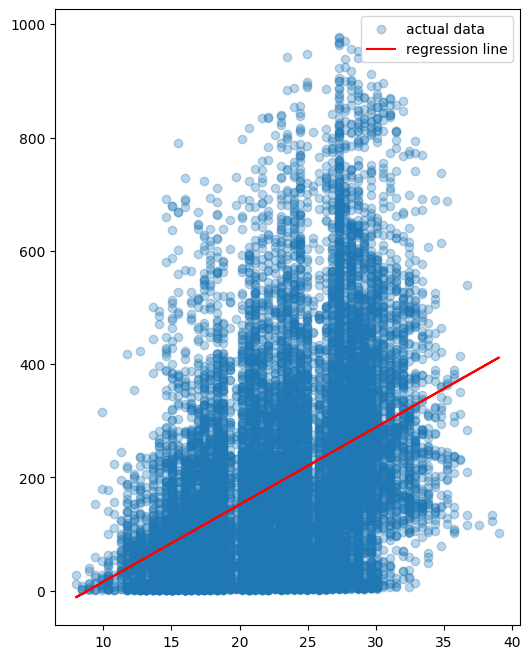

In [113]:
plt.figure(figsize=(6,8))
plt.scatter(X,y,alpha=0.3, label='actual data')
plt.plot(X,y_pred, color='red', label ='regression line')
plt.legend()
plt.show()